In [1]:
from dotenv import load_dotenv

load_dotenv()
# OR, the same with increased verbosity
load_dotenv(verbose=True)
# OR, explicitly providing path to '.env'
from pathlib import Path  # Python 3.6+ only
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [2]:
from util.dataset import create_flowers_ds
from util.pretext import rotate
from util.utils import show_image
from tensorflow.python.ops.numpy_ops import np_config


np_config.enable_numpy_behavior()

In [4]:
ds = create_flowers_ds()

Creating dataset TF Flowers
Loading dataset: tf_flowers


2022-03-25 14:24:15.753498: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Found 3840 datapoints belonging to 5 classes:
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
 Using 2816 for training, 768 for validation, and reserved 256 for testing


2022-03-25 14:24:18.849133: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-03-25 14:24:34.873724: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


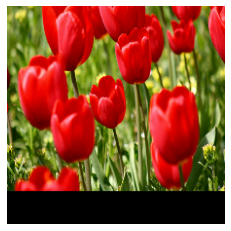

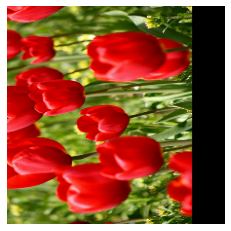

In [6]:
batch = [x for x,y in ds.train.take(1)]

img = batch[0][0]

show_image(img)

rotated_img = rotate(img, 0, 1)[0]
show_image(rotated_img)